In [1]:
import Random
Random.seed!(0)
pwd()

"/home/bach/iskra"

In [2]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

In [3]:
nx = 20         # number of nodes in x direction
ny = 20         # number of nodes in y direction
ts = 200        # number of time steps
Δh = 5cm        # cell size
Δt = 50ns       # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [4]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
sx, sv = [0 Lx; 0 Ly], [0 0; 0 0]
O  = create_fluid_species("O",  0.0, 0qe, 8mp, nx+1, ny+1);
iO = create_fluid_species("O+", 0.0,+1qe, 8mp, nx+1, ny+1);
e  = create_fluid_species("e-", 1.0,-1qe, 1me, nx+1, ny+1);

In [5]:
import RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = RegularGrid.create_uniform_grid(xs, ys)
config.cells   = RegularGrid.create_staggered_grid(config.grid)
config.solver  = FiniteDifferenceMethod.create_poisson_solver(config.grid, ε0)
config.pusher  = ParticleInCell.create_boris_pusher()
config.species = [O, iO, e]

using Chemistry
#σ = CrossSection(0:0.3:1.5, [0, 0.1e-4, 0.4e-4, 0.5e-4, 0.7e-4, 0.9e-4])
σ(E) = 2
chemistry = chemical(@reactions begin
    σ, e + O --> 2e + iO
end)
config.interactions = [chemistry]

┌ Info: Precompiling Chemistry [top-level]
└ @ Base loading.jl:1260


1-element Array{ChemicalReactionNetwork,1}:
 ChemicalReactionNetwork(ChemicalReaction[σ, Tuple{ParticleInCell.FluidSpecies,Int64}[(e-, 1), (O, 1)]:Tuple{ParticleInCell.FluidSpecies,Int64}[(e-, 1), (O, -1), (O+, 1)]])

In [6]:
nx, ny = size(config.grid)
mx, my = size(config.cells)
xx, yy = config.grid.x, config.grid.y
δ = @. exp(-(xx-0.5Lx)^2/0.03Lx -(yy-0.5Ly)^2/0.03Ly)
εr  = ones(mx, my, 1)
bcs = zeros(Int8, nx, ny, 1)
bcs[ nx,  1, 1] = 1
bcs[ nx, ny, 1] = 2
set_permittivity(εr)
create_electrode(bcs .== 1, config; σ=1ε0)
create_electrode(bcs .== 2, config; fixed=true)

ParticleInCell.FixedPotentialElectrode(fill(0.0), 0.0, 0.0)

In [7]:
import Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  Diagnostics.new_iteration("03_chemistry", i, t, dt) do it
    Diagnostics.save_diagnostic(it, "nO")
    Diagnostics.save_diagnostic(it, "nO+")
    Diagnostics.save_diagnostic(it, "ne-")
    Diagnostics.save_diagnostic(it, "dO")
    Diagnostics.save_diagnostic(it, "dO+")
    Diagnostics.save_diagnostic(it, "de-")
    Diagnostics.save_diagnostic(it, "phi")
    Diagnostics.save_diagnostic(it, "E")
  end
end

nothing

In [8]:
ParticleInCell.init(ParticleInCell.DensitySource(1e6δ, config.grid), O, Δt)
ParticleInCell.init(ParticleInCell.DensitySource(1e4δ, config.grid), e, Δt)
@time ParticleInCell.solve(config, Δt, ts)

New diagnostics registered: dO
New diagnostics registered: dO+
New diagnostics registered: de-
New diagnostics registered: vO
New diagnostics registered: vO+
New diagnostics registered: ve-
New diagnostics registered: nO
New diagnostics registered: nO+
New diagnostics registered: ne-
New diagnostics registered: rho
New diagnostics registered: phi
New diagnostics registered: E
Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34
Time Step #35
Time Step #36
Time Step #37
Time Step #38
Time Step #39
Time Step #40
Time Step #41
Time Step #42
Time Step #43
Time Step #44
Time Step #45


### Analysis

In [9]:
using PyPlot
using PyCall
ov  = pyimport("openpmd_viewer");
ts = ov.OpenPMDTimeSeries("/tmp/03_chemistry/hdf5");

In [10]:
ts.get_field("nO+", iteration=10, plot=false);

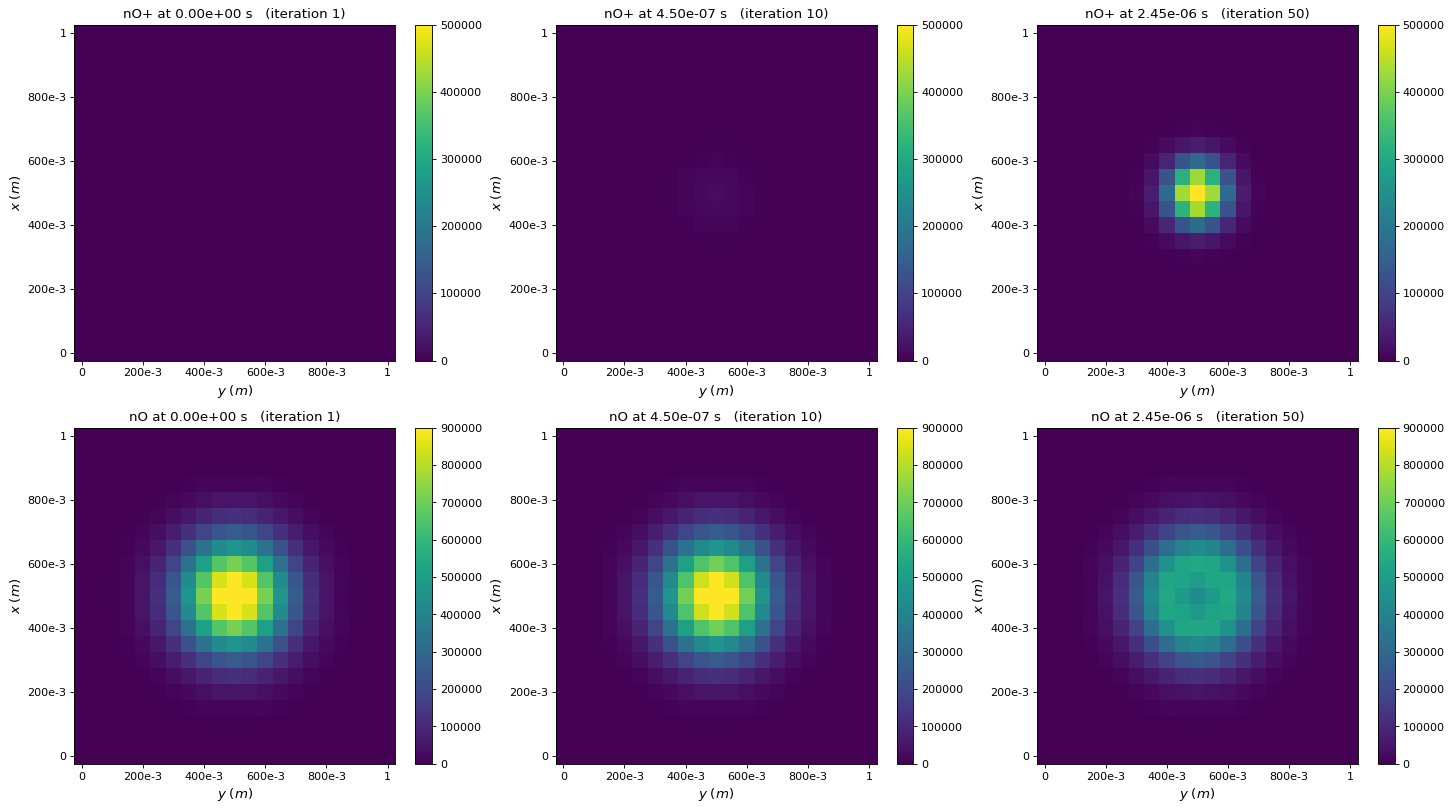

In [11]:
fig = plt.figure(figsize=(22, 12), dpi= 80, facecolor="w", edgecolor="k")

plt.subplot(2, 3, 1); ts.get_field("nO+", iteration=1,  plot=true); clim(0, 500_000)
plt.subplot(2, 3, 2); ts.get_field("nO+", iteration=10, plot=true); clim(0, 500_000)
plt.subplot(2, 3, 3); ts.get_field("nO+", iteration=50, plot=true); clim(0, 500_000)

plt.subplot(2, 3, 4); ts.get_field("nO",  iteration=1,  plot=true); clim(0, 900_000)
plt.subplot(2, 3, 5); ts.get_field("nO",  iteration=10, plot=true); clim(0, 900_000)
plt.subplot(2, 3, 6); ts.get_field("nO",  iteration=50, plot=true); clim(0, 900_000)